Let's first visualize the downloaded DEM file

File Bounds: BoundingBox(left=446320.0, bottom=4238528.000032917, right=449477.0, top=4241739.000032917)
Coordinate System: EPSG:26917


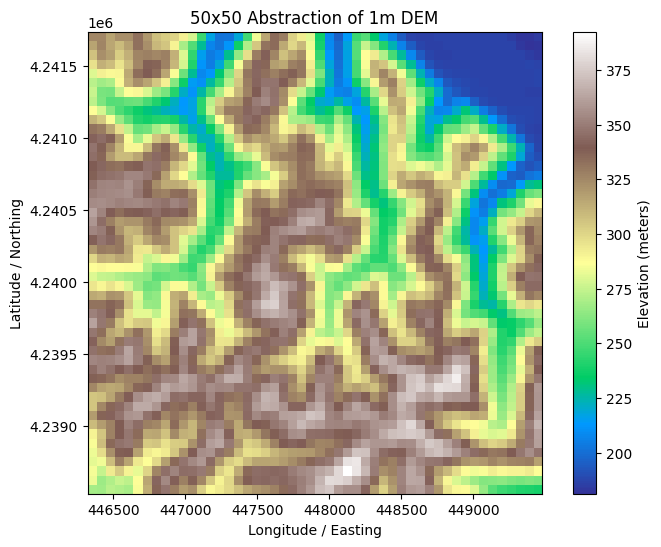

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path if it isn't there already
if project_root not in sys.path:
    sys.path.append(project_root)

import rasterio
import matplotlib.pyplot as plt
import numpy as np

from rasterio.enums import Resampling

def get_grid_from_local_dem(file_path, n_size):
    """
    Automatically detects bounds from a local 1m DEM and 
    resamples it to an N x N grid.
    """
    with rasterio.open(file_path) as dataset:
        # 1. Automatically get metadata/bounds
        bounds = dataset.bounds
        crs = dataset.crs
        print(f"File Bounds: {bounds}")
        print(f"Coordinate System: {crs}")

        # 2. Resample during read (Memory efficient)
        # We specify the output shape as (1, n_size, n_size) for (band, height, width)
        data = dataset.read(
            1,
            out_shape=(n_size, n_size),
            resampling=Resampling.bilinear # Or Resampling.max to preserve peaks
        )
        
        # 3. Handle NoData values (common in 1m DEMs)
        if dataset.nodata is not None:
            data = np.where(data == dataset.nodata, np.nan, data)

        return data, bounds

# --- Execution ---
# Replace with your West Virginia file path
dem_path = 'WV_DEM.tif' 
N = 50 

height_grid, dem_bounds = get_grid_from_local_dem(dem_path, N)

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(height_grid, cmap='terrain', extent=[dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top])
plt.colorbar(label='Elevation (meters)')
plt.title(f"{N}x{N} Abstraction of 1m DEM")
plt.xlabel("Longitude / Easting")
plt.ylabel("Latitude / Northing")
plt.show()

Let's now visualize the corresponding graph

In [2]:
from real_map_generation import RealTerrainGrid
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np  # For any distance calcs if needed

# Rotate clockwise 90 degrees to counteract the anticlockwise shift
corrected_height_grid = np.rot90(height_grid, k=-1)

graph_generator = RealTerrainGrid(corrected_height_grid, k_up=1.0, k_down=2.0)
# Note that for some reason the x and y axes are flipped
# graph_generator.add_obstacle(center=(59,86), rx=3, ry=6)
# graph_generator.add_obstacle(center={45,54}, rx=4, ry=4)
# graph_generator.add_obstacle(center=(88,55), rx=3, ry=6)
# graph_generator.add_obstacle(center=(77,25), rx=4, ry=4)

graph_generator.compute_all_visibilities()
env_graph = graph_generator.get_graph()


/var/folders/sz/hz_r9sdd0978ddwt1zk8pj8m0000gn/T/ipykernel_36281/1879484912.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


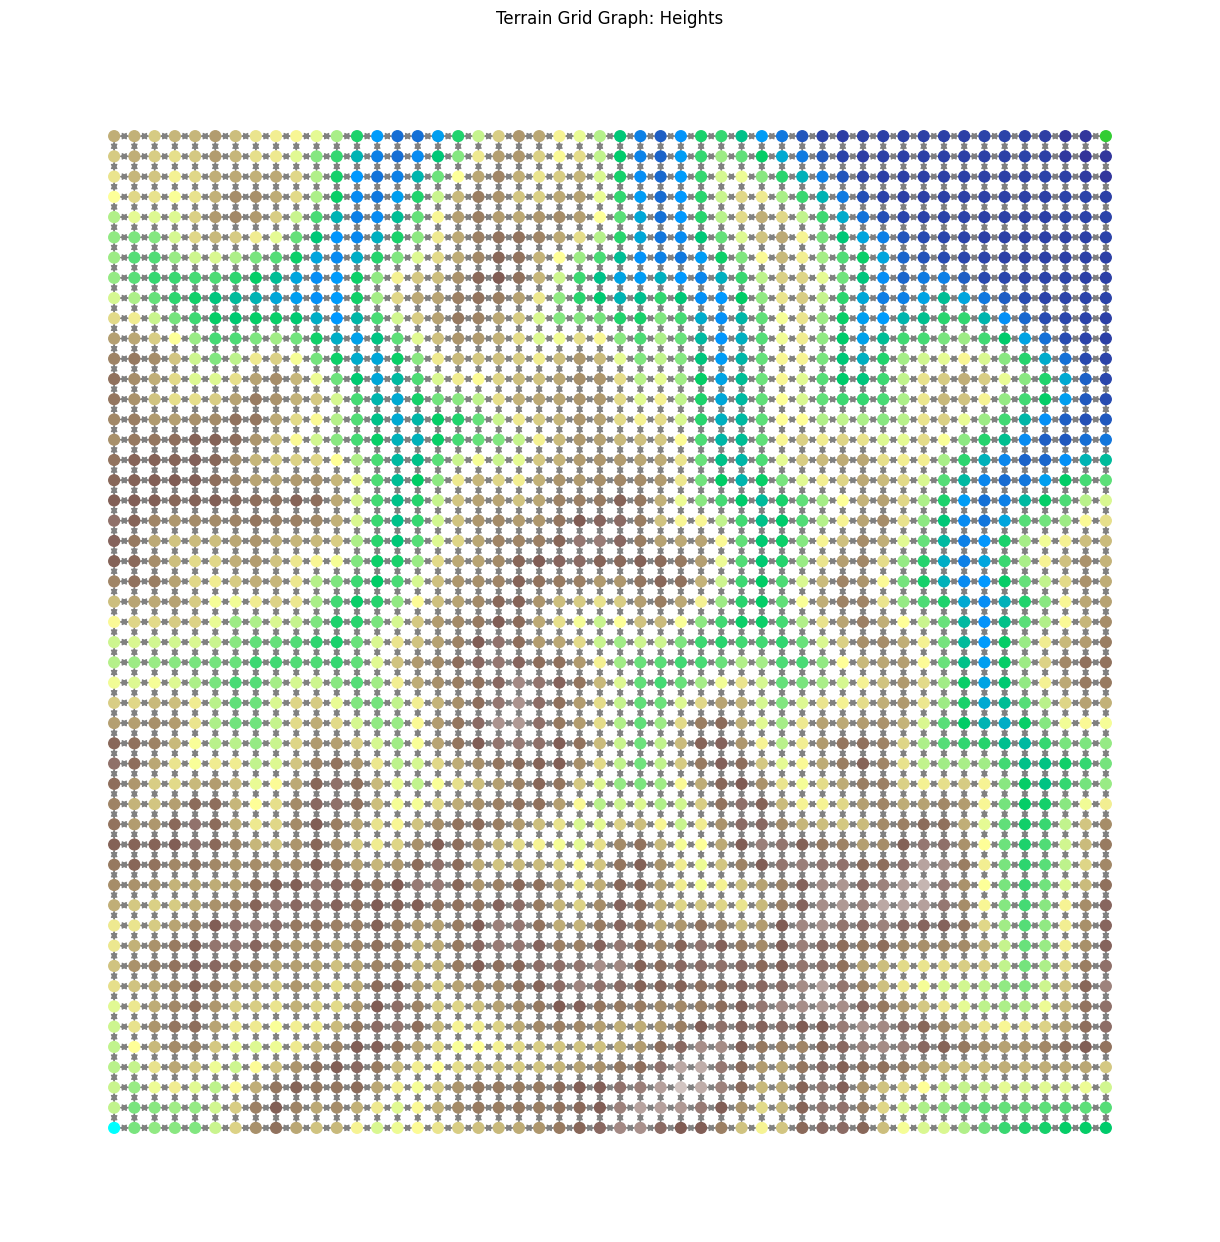

In [3]:

# --- 0. Select the Observer (your vision viewpoint) ---
observer_node = (55, 81) 

# Retrieve visible edges as sorted tuples for lookup
visible_set = []
# visible_set = set(tuple(sorted(e)) for e in env_graph.nodes[observer_node].get("visible_edges", []))

# 1. Setup Data for Plotting
pos = nx.get_node_attributes(env_graph, 'pos')
edge_labels = nx.get_edge_attributes(env_graph, 'distance')  # Or compute if missing
formatted_edge_labels = {k: f"{v:.1f}" for k, v in edge_labels.items()}

# 2. Setup Colormap for Heights
all_heights = [data.get('height', 0) for _, data in env_graph.nodes(data=True)]
max_height = max(all_heights) if all_heights else 1
norm = mcolors.Normalize(vmin=0, vmax=max_height + 1)
cmap = plt.cm.terrain

# 3. Build Node Color List
color_map = []
for node, data in env_graph.nodes(data=True):
    node_type = data.get("type", "intermediate")
    if node_type == "source":
        color_map.append("limegreen")  
    elif node_type == "target_unreached":
        color_map.append("cyan")     
    elif node_type == "obstacle":
        color_map.append("black")
    else:
        h = data.get('height', 0)
        rgba_color = cmap(norm(h))
        color_map.append(rgba_color)

# 4. Edge Colors (gold for visible from observer)
edge_color_map = []
for u, v in env_graph.edges():
    edge_key = tuple(sorted((u, v)))
    if edge_key in visible_set:
        edge_color_map.append('gold')
    else:
        edge_color_map.append('gray')

# 5. Draw the Graph
plt.figure(figsize=(12, 12))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False,
    node_size=60,
    font_color='white',
    font_weight='bold',
    width=0.8,
    edge_color=edge_color_map
)

# Fixed: Pass the dict here
nx.draw_networkx_edge_labels(
    env_graph,
    pos,
    edge_labels=False,  
    font_size=8,
    label_pos=0.5
)

plt.title(f"Terrain Grid Graph: Heights")
plt.axis('off')
plt.tight_layout()
plt.show()

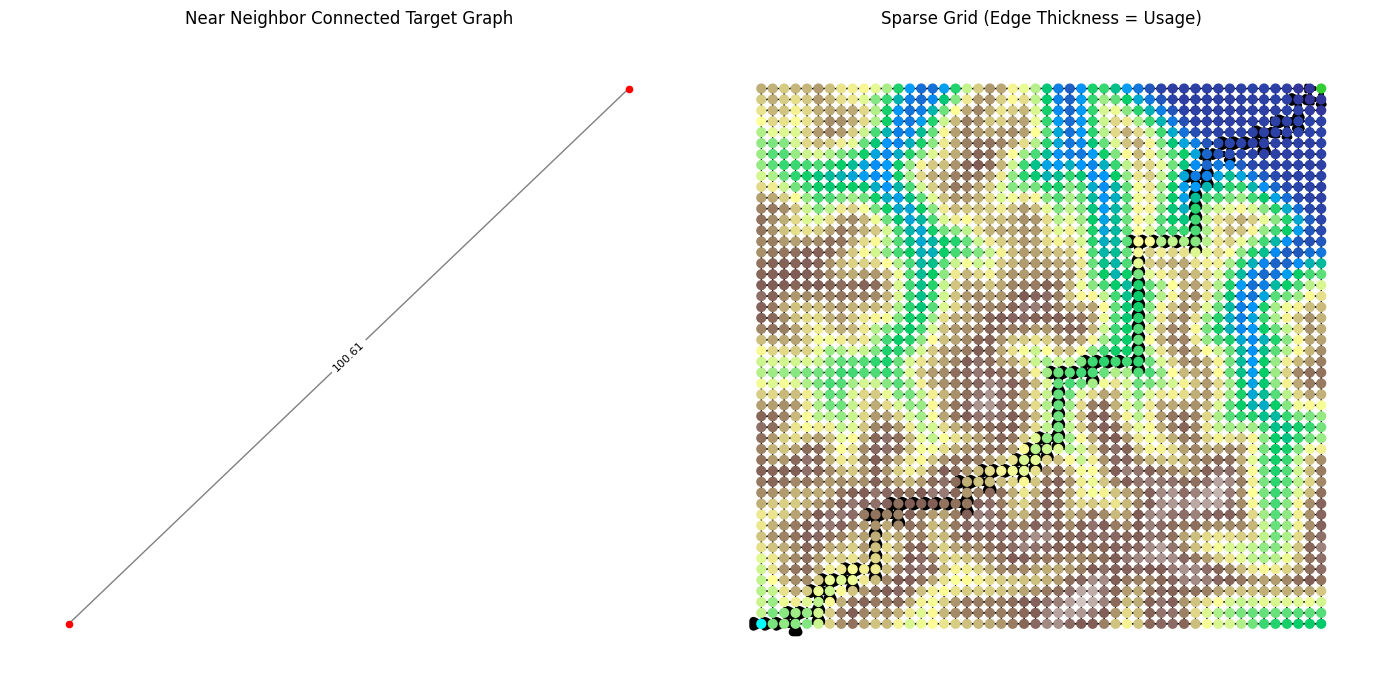

In [4]:
from Graph_Generation.target_graph import create_fully_connected_target_graph

target_graph = create_fully_connected_target_graph(env_graph)

# --- 1. Prepare for Plotting ---

edge_labels = {}
for u, v, data in target_graph.edges(data=True):
    distance = data['distance']
    edge_labels[(u, v)] = f"{distance:.2f}"

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 5.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Near Neighbor Connected Target Graph")
nx.draw(
    target_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=False,
    node_size=20,
    width=1.0,
    edge_color='grey'
)

nx.draw_networkx_edge_labels(
    target_graph, 
    pos=pos,
    ax =axes[0],
    edge_labels=edge_labels,
    font_size=8
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Sparse Grid (Edge Thickness = Usage)")
nx.draw(
    env_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Let's see what the shortest path agent intends to do

In [5]:
from Graph_Generation.target_graph import create_fully_connected_target_graph

# target_graph = create_fully_connected_target_graph(env_graph)

shortest_path = nx.shortest_path(env_graph, source=(49,49), target=(0,0), weight="distance")
paths_generator = nx.shortest_simple_paths(env_graph, source=(49,49), target=(0,0), weight="distance")

Let's also create an interactive version of the map

In [4]:
import plotly.graph_objects as go

def plot_interactive_env_graph(env_graph, observer_node=None):
    # 1. Prepare Positions and Visibility
    pos = nx.get_node_attributes(env_graph, 'pos')
    
    # Standardize visible edges for lookup
    visible_set = set()
    if observer_node and "visible_edges" in env_graph.nodes[observer_node]:
        visible_set = set(tuple(sorted(e)) for e in env_graph.nodes[observer_node]["visible_edges"])

    # 2. Build Edge Traces (Gray for hidden, Gold for visible)
    # We split them into two traces so they can be toggled in the legend
    edge_x_hidden, edge_y_hidden = [], []
    edge_x_visible, edge_y_visible = [], []

    for u, v in env_graph.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_key = tuple(sorted((u, v)))
        
        if edge_key in visible_set:
            edge_x_visible.extend([x0, x1, None])
            edge_y_visible.extend([y0, y1, None])
        else:
            edge_x_hidden.extend([x0, x1, None])
            edge_y_hidden.extend([y0, y1, None])

    # 3. Build Node Traces
    node_x, node_y = [], []
    node_color, node_text, node_size = [], [], []

    for node, data in env_graph.nodes(data=True):
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Metadata for Hover
        h = data.get('height', 0)
        dist_info = "" # You could add sum of edge weights here
        node_text.append(f"Node: {node}<br>Height: {h:.2f}<br>Type: {data.get('type')}")

        # Color Logic
        if data.get("type") == "source":
            node_color.append('limegreen')
            node_size.append(15)
        elif data.get("type") == "target":
            node_color.append('cyan')
            node_size.append(15)
        else:
            # Using Plotly's internal terrain-like colorscale (Earth)
            node_color.append(h) 
            node_size.append(8)

    # 4. Create the Figure
    fig = go.Figure()

    # Add Hidden Edges
    fig.add_trace(go.Scatter(
        x=edge_x_hidden, y=edge_y_hidden,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none', mode='lines', name='Hidden Edges'
    ))

    # Add Visible Edges (Gold)
    fig.add_trace(go.Scatter(
        x=edge_x_visible, y=edge_y_visible,
        line=dict(width=2, color='gold'),
        hoverinfo='none', mode='lines', name='Visible from Observer'
    ))

    # Add Nodes
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        name='Terrain Nodes',
        marker=dict(
            showscale=True,
            colorscale='Earth',
            color=node_color,
            size=node_size,
            colorbar=dict(title='Height', thickness=15, x=1.02),
            line_width=1
        ),
        text=node_text,
        hoverinfo='text'
    ))

    # Layout tweaks
    fig.update_layout(
        title=f"Interactive Terrain Graph",
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white'
    )

    return fig

# --- Execution ---
fig = plot_interactive_env_graph(env_graph)
fig.show(renderer="browser")